In [1]:
cd C:\Users\Mahendiran\OneDrive\Desktop

C:\Users\Mahendiran\OneDrive\Desktop


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
iris = load_iris()
x = iris.data
y = iris.target
features = iris.feature_names
target = iris.target_names

In [4]:
iris = pd.DataFrame(x)

In [5]:
iris.columns = features
iris["species"] = y

In [6]:
iris.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
67,5.8,2.7,4.1,1.0,1
104,6.5,3.0,5.8,2.2,2
100,6.3,3.3,6.0,2.5,2
143,6.8,3.2,5.9,2.3,2
65,6.7,3.1,4.4,1.4,1


In [7]:
print(iris.shape)
print(iris.info())
print(iris.columns)
print(iris.describe())
print(iris.isnull().sum())
print(iris.duplicated().sum())

(150, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB
None
Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'species'],
      dtype='object')
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.80000

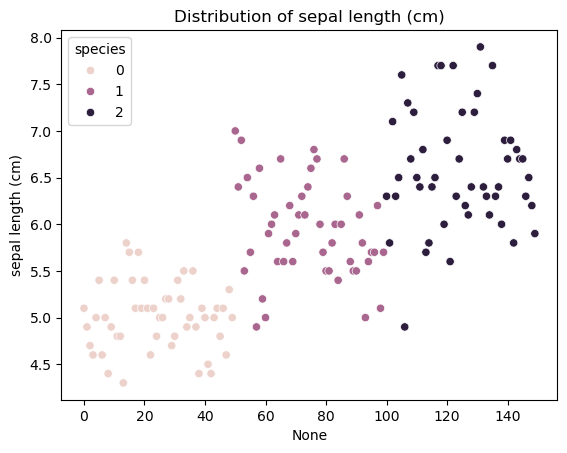

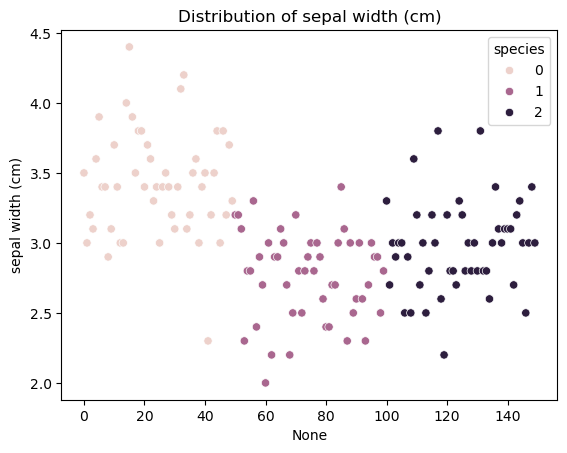

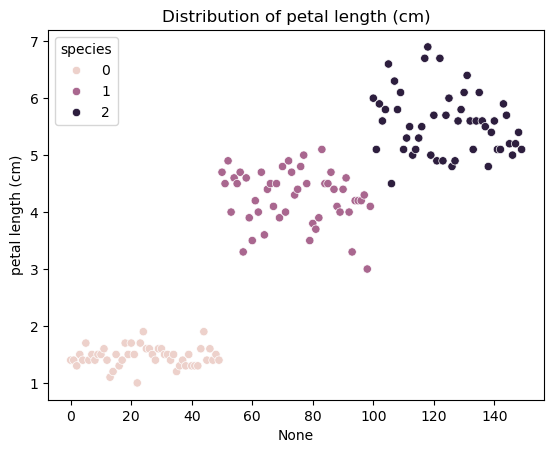

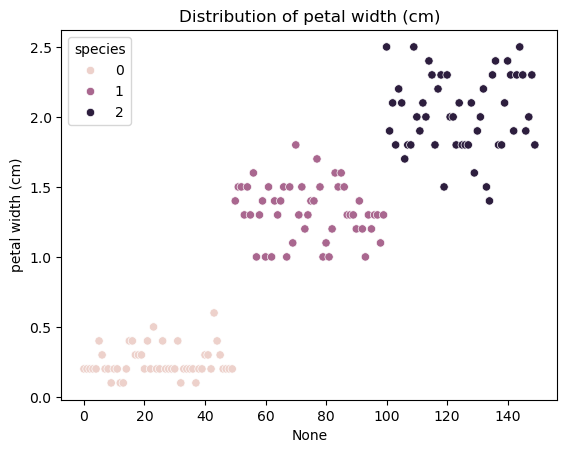

In [8]:
for i in iris.columns:
    if i == 'species': 
        continue
    sns.scatterplot(data=iris, x=iris.index, y=i, hue="species")
    plt.title(f"Distribution of {i}")
    plt.show()

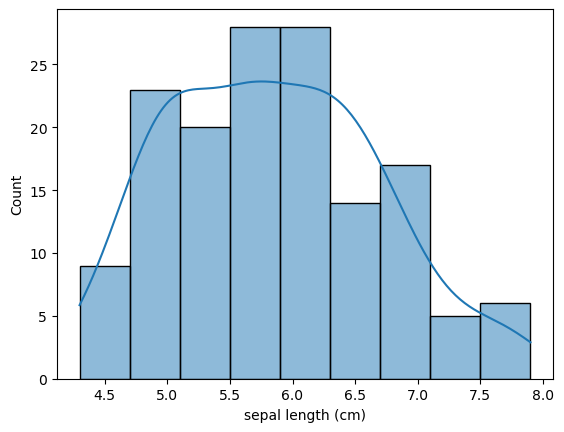

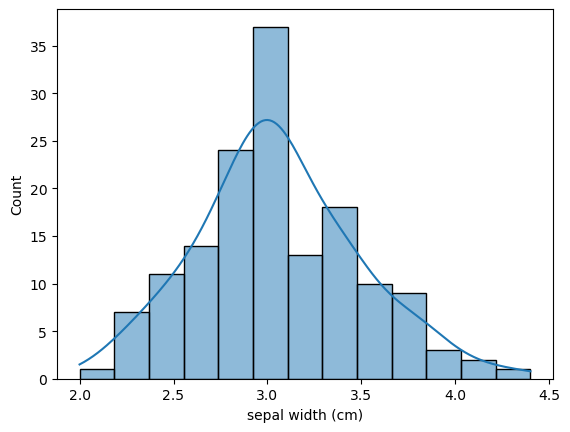

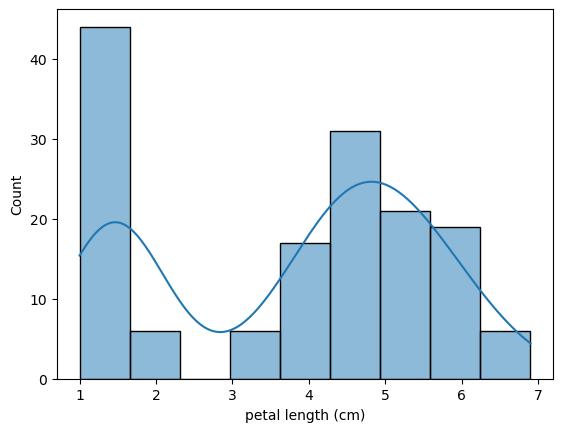

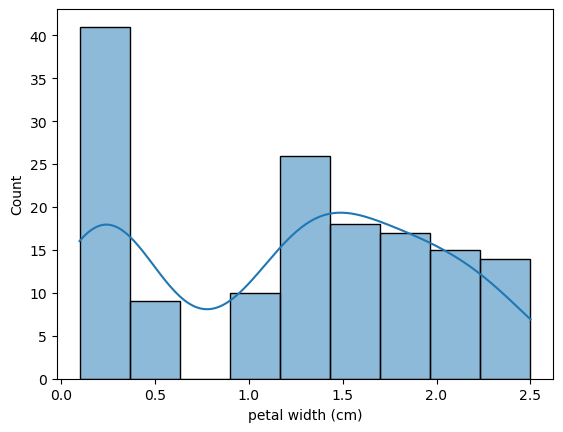

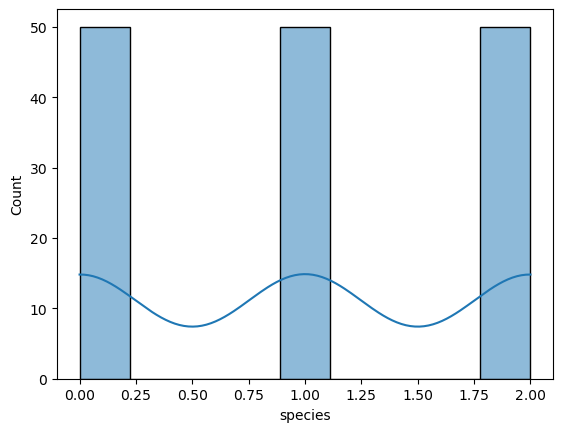

In [9]:
for i in iris.columns:
    sns.histplot(iris[i], kde = True)
    plt.show()

In [10]:
X = iris.iloc[0:,0:4]
Y = iris["species"]

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, stratify = y, random_state = 56)

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

best_scalers = {}

for col in X_train.columns:
    data = X_train[[col]]
    
    s_data = StandardScaler().fit_transform(data)
    r_data = RobustScaler().fit_transform(data)
    mm_data = MinMaxScaler().fit_transform(data)
    
    results = {
        'Standard': s_data.std(),
        'Robust': r_data.std(),
        'MinMax': mm_data.std()
    }
    
    best_name = min(results, key=results.get)
    best_scalers[col] = best_name

for feature, scaler in best_scalers.items():
    print(f"Feature: {feature:20} | Best Scaler: {scaler}")

Feature: sepal length (cm)    | Best Scaler: MinMax
Feature: sepal width (cm)     | Best Scaler: MinMax
Feature: petal length (cm)    | Best Scaler: MinMax
Feature: petal width (cm)     | Best Scaler: MinMax


In [68]:
# Pipeline to prevent data leakage and just trying that how data is for prediction 
final = Pipeline([
        ("scale",MinMaxScaler()),
        ("logistic",LogisticRegression()),
])

In [69]:
# Train on the model and predicting to get accuracy score 
final.fit(X_train,Y_train)
y_pred = final.predict(X_test)

In [70]:
# just to see how the model is performing 
accuracy_score(Y_test,y_pred)

0.9666666666666667

In [71]:
# Trying to get stable real value
scores = cross_val_score(final,X,Y, cv = 6 )

In [72]:
print(scores.mean())

0.9266666666666667


In [73]:
# To find the best model, and suprisingly i am able to see SVM is giving best result
models_to_test = {
    "Logistic" : LogisticRegression(),
    "KNN" : KNeighborsClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "SVM" : SVC()
}

for name, model in models_to_test.items():
    current_final = Pipeline([
        ("scale",MinMaxScaler()),
        ("model",model)
    ])
    cv_scores = cross_val_score(current_final,X,Y, cv = 14 )
    avg_score = cv_scores.mean()
    print(f"{name :} {avg_score:.4f}")
    print(f"{name :} {avg_score.std():.10f}")
    


Logistic 0.9208
Logistic 0.0000000000
KNN 0.9545
KNN 0.0000000000
Random Forest 0.9610
Random Forest 0.0000000000
SVM 0.9675
SVM 0.0000000000


In [77]:
# Trying HyperParameterTuning for first time 
svm_final = Pipeline([
        ("scale",MinMaxScaler()),
        ("svm",SVC()),
])
param_grid = {
    "svm__C":[0.1, 1, 10, 100],
    "svm__gamma": [1, 0.1, 0.01, 0.001],
    "svm__kernel": ["rbf", "linear"]
}

grid = GridSearchCV(
    svm_final,
    param_grid,
    cv = 10,
    n_jobs = -1,
    verbose = 1
)

grid.fit(X_train,Y_train)
print("Best parameters :", grid.best_params_)
print("Best score :", grid.best_score_)

test_score = grid.score(X_test, Y_test)
print(f"Training Score : {grid.best_score_:.4f}")
print(f"Test Score Real : {test_score:.4f}")

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best parameters : {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'linear'}
Best score : 0.9916666666666666
Training Score : 0.9917
Test Score Real : 0.9667


In [75]:
# Getting Classification Report to see where the model is making mistake 
Y_pred = grid.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

